# Setup

In [ ]:
%pip install kornia==0.4.0
%pip install opencv-contrib-python==3.4.2.17
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math 
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import kornia as K
import time

## Mount drive

In [ ]:
your_path = ''
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/'+your_path
import sys
sys.path.append(path)
from utils.points import cords_to_map

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# choose image path

In [ ]:
img_path = path + '/datasets/video_data/video_images/'

## GPU

In [ ]:
print(torch.__version__)
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  DEVICE = 'cpu'
  print('CUDA is not available.  Training on CPU ...')
else:
  DEVICE = 'cuda'
  print('CUDA is available!  Training on GPU ...')



1.6.0
CUDA is available!  Training on GPU ...


# DATA

## Generate list dataset 

In [ ]:
import PIL
import numpy as np
import glob
import os

def sortKeyFunc(s):
    return int(s[5:-4])

lst = glob.glob(path+'/datasets/video_data/video_images/*')
lst = sorted([os.path.basename(x) for x in lst], key=sortKeyFunc)
print(lst)



['frame0.jpg', 'frame1.jpg', 'frame2.jpg', 'frame3.jpg', 'frame4.jpg', 'frame5.jpg', 'frame6.jpg', 'frame7.jpg', 'frame8.jpg', 'frame9.jpg', 'frame10.jpg', 'frame11.jpg', 'frame12.jpg', 'frame13.jpg', 'frame14.jpg', 'frame15.jpg', 'frame16.jpg', 'frame17.jpg', 'frame18.jpg', 'frame19.jpg', 'frame20.jpg', 'frame21.jpg', 'frame22.jpg', 'frame23.jpg', 'frame24.jpg', 'frame25.jpg', 'frame26.jpg', 'frame27.jpg', 'frame28.jpg', 'frame29.jpg', 'frame30.jpg', 'frame31.jpg', 'frame32.jpg', 'frame33.jpg', 'frame34.jpg', 'frame35.jpg', 'frame36.jpg', 'frame37.jpg', 'frame38.jpg', 'frame39.jpg', 'frame40.jpg', 'frame41.jpg', 'frame42.jpg', 'frame43.jpg', 'frame44.jpg', 'frame45.jpg', 'frame46.jpg', 'frame47.jpg', 'frame48.jpg', 'frame49.jpg', 'frame50.jpg', 'frame51.jpg', 'frame52.jpg', 'frame53.jpg', 'frame54.jpg', 'frame55.jpg', 'frame56.jpg', 'frame57.jpg', 'frame58.jpg', 'frame59.jpg', 'frame60.jpg', 'frame61.jpg', 'frame62.jpg', 'frame63.jpg', 'frame64.jpg', 'frame65.jpg', 'frame66.jpg', 'fra

### plot function

In [ ]:
from utils.plot import plot_imgs


# Net architecture

## Superpoint model

In [ ]:
from models.superpoint import SuperPointNet

# magic leap model with train on images from video
extra_train_model = SuperPointNet(superpoint_bool=True).to(DEVICE)
weights_path = path+'/weights/super_coco_weights_video.pth'  
extra_train_model.load_state_dict(torch.load(weights_path,
                               map_location=lambda storage, loc: storage))
extra_train_model.eval()


# our model
our_model = SuperPointNet(superpoint_bool=True).to(DEVICE)
weights_path = path+'/weights/super_coco_weights.pth'  
our_model.load_state_dict(torch.load(weights_path,
                               map_location=lambda storage, loc: storage))
our_model.eval()



# magic leap model
magicleap_model = SuperPointNet(superpoint_bool=True).to(DEVICE)
weights_path = path+'/pretrained_weights/superpoint_v1.pth'  
magicleap_model.load_state_dict(torch.load(weights_path,
                               map_location=lambda storage, loc: storage))
magicleap_model.eval()

SuperPointNet(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d

## functions for Loss calculations

In [ ]:
from models.utils import detector_loss, descriptor_loss


# Evaluations

## import functions

In [ ]:
from utils.points import get_prob_map, nms, get_descriptors
from models.superpoint import get_descriptors, superpoint_frontend

## See key points detected with different methods

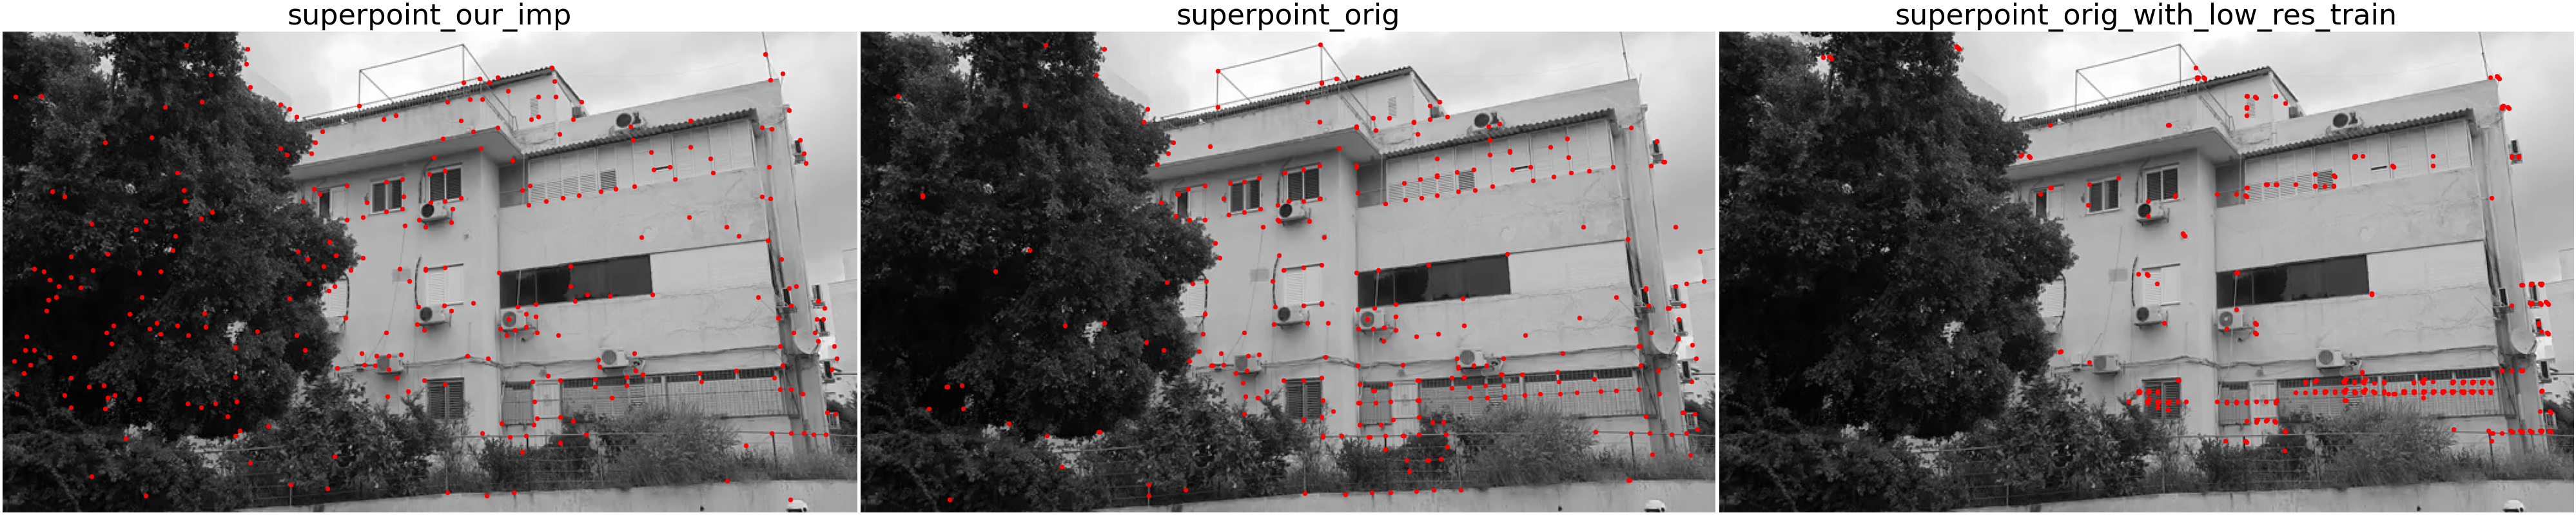

(300, 1, 2)


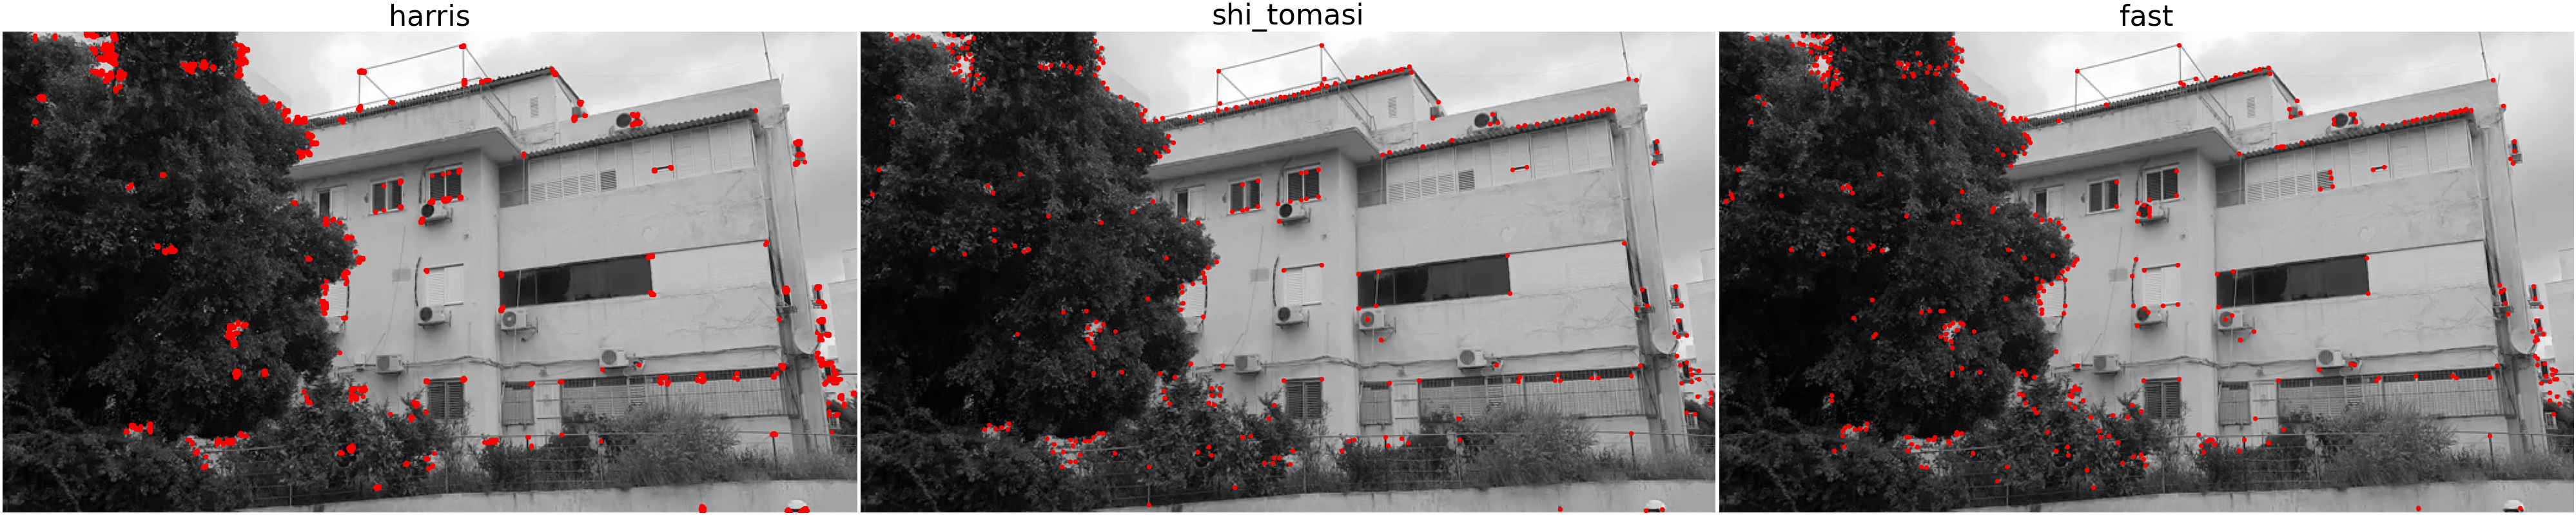

In [ ]:
im = PIL.Image.open(img_path+lst[0])
orig_im = np.asarray(im)
im2 = PIL.Image.open(img_path+lst[2])
orig_im2 = np.asarray(im2)

plt.figure(figsize=(100, 400), dpi=40)

#superpoint(our model)
points, desc = superpoint_frontend(orig_im, our_model,num_points=300)
plt.subplot(231)
plt.imshow(orig_im,cmap='gray')
plt.scatter(x=points[:,0], y=points[:,1], c='r', s=150)
plt.axis('off')
plt.title('superpoint_our_imp',fontsize=80)
plt.tight_layout()

#superpoint(magicleap model)
points, desc = superpoint_frontend(orig_im, magicleap_model,num_points=300)
plt.subplot(232)
plt.imshow(orig_im,cmap='gray')
plt.scatter(x=points[:,0], y=points[:,1], c='r', s=150)
plt.axis('off')
plt.title('superpoint_orig',fontsize=80)
plt.tight_layout()

#superpoint(magicleap model with specific task training)
points, desc = superpoint_frontend(orig_im, extra_train_model,num_points=300)
plt.subplot(233)
plt.imshow(orig_im,cmap='gray')
plt.scatter(x=points[:,0], y=points[:,1], c='r', s=150)
plt.axis('off')
plt.title('superpoint_orig_with_low_res_train',fontsize=80)
plt.tight_layout()
plt.show()

plt.figure(figsize=(100, 400), dpi=40)

#harris
har_cords = cv2.cornerHarris(orig_im,4, 5,0.15)
har_cords = np.where(har_cords>0.015)
plt.subplot(234)
plt.imshow(orig_im,cmap='gray')
plt.scatter(x=har_cords[1], y=har_cords[0], c='r', s=150)
plt.axis('off')
plt.title('harris',fontsize=80)
plt.tight_layout()


#goodfeturestotrack
feat_cords = cv2.goodFeaturesToTrack(orig_im,300,0.015,4)
print(feat_cords.shape)
plt.subplot(235)
plt.imshow(orig_im,cmap='gray')
plt.scatter(x=feat_cords[:,0,0], y=feat_cords[:,0,1], c='r', s=150)
plt.axis('off')
plt.title('shi_tomasi',fontsize=80)
plt.tight_layout()

#fast
fast = cv2.FastFeatureDetector_create(70,nonmaxSuppression=True)
corners = fast.detect(orig_im.astype(np.uint8))
detections = np.zeros(orig_im.shape[:2], np.float)
for c in corners:
    detections[tuple(np.flip(np.int0(c.pt), 0))] = c.response
fast_cords = np.where(detections>1)
plt.subplot(236)
plt.imshow(orig_im,cmap='gray')
plt.scatter(x=fast_cords[1], y=fast_cords[0], c='r', s=150)
plt.axis('off')
plt.title('fast',fontsize=80)


plt.tight_layout()
plt.show()




## sift point tracking and matching

(1309, 128)
(776,)
<DMatch 0x7fea1178abf0>
(1309, 2)
time past:0.6941478252410889 sec


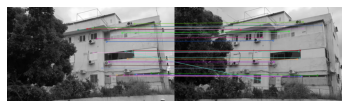

(200, 2)


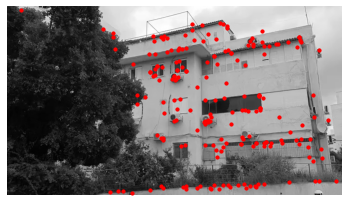

In [ ]:
import cv2 
import matplotlib.pyplot as plt
import time

%matplotlib inline
t_0 = time.time()
# read images
img1 = cv2.imread(img_path+lst[0])  
img2 = cv2.imread(img_path+lst[200]) 



#img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
print((descriptors_1.shape))
#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)
matches_idx = np.array([m.queryIdx for m in matches],dtype=int)
print(matches_idx.shape)
print(matches[0])


# from keypoints to array
kp_1 = np.array([keypoints_1[idx].pt for idx in range(len(keypoints_1))])
kp_2 = np.array([keypoints_2[idx].pt for idx in range(len(keypoints_2))])
print(kp_1.shape)
# from array to keypoints
keypoints_1 = [cv2.KeyPoint(x[0], x[1], 1) for x in kp_1]
keypoints_2 = [cv2.KeyPoint(x[0], x[1], 1) for x in kp_2]

t_f = time.time()
print('time past:{} sec'.format(t_f-t_0))

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:30], img2, flags=2)
plt.axis('off')
plt.imshow(img3),plt.show()

pts = np.array([keypoints_1[idx].pt for idx in matches_idx[:200]])
print(pts.shape)

implot = plt.imshow(img1,cmap='gray')
plt.scatter(x=pts[:,0], y=pts[:,1], c='r', s=10)
plt.axis('off')
plt.show()


## superpoint point tracking and matching

time past:0.08338284492492676 sec


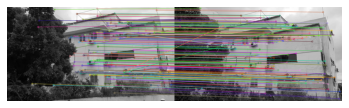

(<matplotlib.image.AxesImage at 0x7fea116f2210>, None)

In [ ]:
model = magicleap_model

resize = False

import time
im = PIL.Image.open(img_path+lst[0])

im2 = PIL.Image.open(img_path+lst[300])
if resize:
  im2 = im2.resize((320,240))
  im = im.resize((320,240))
  
orig_im1 = np.asarray(im)
orig_im2 = np.asarray(im2)
t_0 = time.time()
points, desc = superpoint_frontend(im, model,num_points=500)
points2, desc2 = superpoint_frontend(im2, model,num_points=500)

keypoints_1 = [cv2.KeyPoint(x[0], x[1], 1) for x in points]
keypoints_2 = [cv2.KeyPoint(x[0], x[1], 1) for x in points2]

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(desc,desc2)
matches = sorted(matches, key = lambda x:x.distance)
matches_idx = np.array([m.queryIdx for m in matches],dtype=int)
t_f = time.time()
print('time past:{} sec'.format(t_f-t_0))
img3 = cv2.drawMatches(orig_im1, keypoints_1, orig_im2, keypoints_2, matches[:200], orig_im2, flags=2)
plt.axis('off')
plt.imshow(img3),plt.show()


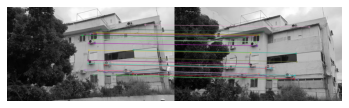

(<matplotlib.image.AxesImage at 0x7fea116428d0>, None)

In [ ]:

img3 = cv2.drawMatches(orig_im1, keypoints_1, orig_im2, keypoints_2, matches[:30], orig_im2, flags=2)
plt.axis('off')
plt.imshow(img3),plt.show()


# eval homography and warp

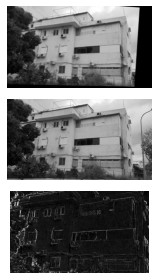

1850115
time past:0.5030620098114014 sec


In [ ]:
model = magicleap_model
import time
resize=True
superpoint=True

im = PIL.Image.open(img_path+lst[150])

im2 = PIL.Image.open(img_path+lst[300])
if resize:
  im_old = im
  im2 = im2.resize((320,240))
  im = im.resize((320,240))
orig_im1 = np.asarray(im)
orig_im2 = np.asarray(im2)


t_0 = time.time()
if superpoint:
    
  points1, desc1 = superpoint_frontend(im, model,num_points=1000)
  points2, desc2 = superpoint_frontend(im2, model,num_points=1000)

  kp1 = [cv2.KeyPoint(x[0], x[1], 1) for x in points1]
  kp2 = [cv2.KeyPoint(x[0], x[1], 1) for x in points2]
else:
  sift = cv2.xfeatures2d.SIFT_create()
  kp1, desc1 = sift.detectAndCompute(img1,None)
  kp2, desc2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(desc1,desc2)
matches = sorted(matches, key = lambda x:x.distance)
kp1 = np.float32([kp1[m.queryIdx].pt for m in matches[:300]]).reshape(-1,1,2)
kp2 = np.float32([kp2[m.trainIdx].pt for m in matches[:300]]).reshape(-1,1,2)

M, mask = cv2.findHomography(kp2, kp1, cv2.RANSAC,5.0)

fake_im1 = cv2.warpPerspective(orig_im2, M,(orig_im1.shape[1],orig_im1.shape[0]))

if resize:
  orig_im1 = np.asarray(im_old)
  fake_im1 = PIL.Image.fromarray(fake_im1)
  fake_im1 = fake_im1.resize((696,392))
  fake_im1 =  np.asarray(fake_im1)


w_board=100
h_board=50


plt.figure(1)
plt.subplot(311)
plt.imshow(fake_im1,cmap='gray')
plt.axis('off')

plt.subplot(312)
plt.imshow(orig_im1,cmap='gray')
plt.axis('off')

plt.subplot(313)
plt.imshow(np.uint8(np.absolute(np.int8(orig_im1)-np.int8(fake_im1))[h_board:-h_board,w_board:-w_board]),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()
print(np.sum(np.absolute(np.int8(orig_im1)-np.int8(fake_im1))[h_board:-h_board,w_board:-w_board]))

t_f = time.time()
print('time past:{} sec'.format(t_f-t_0))


## define time interval eval function

In [ ]:
def get_homography_score(lst,time_dif,superpoint,model,resize=False, num_kp=1000, num_desc=300):
  sum_lst = []
  for i in range(len(lst)-30*time_dif):
    j = i+30*time_dif
    im = PIL.Image.open(img_path+lst[i])
    im2 = PIL.Image.open(img_path+lst[j])
    if resize:
      im_old = im
      im2 = im2.resize((320,240))
      im = im.resize((320,240))


    orig_im1 = np.asarray(im)
    orig_im2 = np.asarray(im2)


    
    if superpoint:
        
      points1, desc1 = superpoint_frontend(im, model,num_points=num_kp)
      points2, desc2 = superpoint_frontend(im2, model,num_points=num_kp)

      kp1 = [cv2.KeyPoint(x[0], x[1], 1) for x in points1]
      kp2 = [cv2.KeyPoint(x[0], x[1], 1) for x in points2]
    else:
      sift = cv2.xfeatures2d.SIFT_create()
      kp1, desc1 = sift.detectAndCompute(img1,None)
      kp2, desc2 = sift.detectAndCompute(img2,None)

    #feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

    matches = bf.match(desc1,desc2)
    matches = sorted(matches, key = lambda x:x.distance)
    kp1 = np.float32([kp1[m.queryIdx].pt for m in matches[:num_desc]]).reshape(-1,1,2)
    kp2 = np.float32([kp2[m.trainIdx].pt for m in matches[:num_desc]]).reshape(-1,1,2)

    M, mask = cv2.findHomography(kp2, kp1, cv2.RANSAC,5.0)

    fake_im1 = cv2.warpPerspective(orig_im2, M,(orig_im1.shape[1],orig_im1.shape[0]))

    if resize:
      orig_im1 = np.asarray(im_old)
      fake_im1 = PIL.Image.fromarray(fake_im1)
      fake_im1 = fake_im1.resize((696,392))
      fake_im1 =  np.asarray(fake_im1)

    
    w_board=100
    h_board=50

    curent_sum = np.sum(np.absolute(np.int8(orig_im1)-np.int8(fake_im1))[h_board:-h_board,w_board:-w_board])
    #print('iteration {}/{}, curent sum is {}'.format(i,len(lst)-30*time_dif,curent_sum))
    sum_lst.append(curent_sum)
  avg_sum = sum(sum_lst)/len(sum_lst)
  return avg_sum

  

In [ ]:
#extra_train_model - original magicleap model with extra video data training


def run(time_interval):

  print('###### time iterval of {} second#######'.format(time_interval))

  t_0 = time.time()
  trained_sum = get_homography_score(lst,time_interval,superpoint=True, resize=False, model=our_model)
  t_f = time.time()
  print('our model high res - sum is {}'.format(int(trained_sum)))
  print('time past:{} sec'.format(int(t_f-t_0)))

  t_0 = time.time()
  trained_sum = get_homography_score(lst,time_interval,superpoint=True, resize=True, model=our_model)
  t_f = time.time()
  print('our model low res - sum is {}'.format(int(trained_sum)))
  print('time past:{} sec'.format(int(t_f-t_0)))

  t_0 = time.time()
  trained_sum = get_homography_score(lst,time_interval,superpoint=True, resize=False, model=extra_train_model)
  t_f = time.time()
  print('extra train high res - sum is {}'.format(int(trained_sum)))
  print('time past:{} sec'.format(int(t_f-t_0)))

  t_0 = time.time()
  trained_sum = get_homography_score(lst,time_interval,superpoint=True, resize=True, model=extra_train_model)
  t_f = time.time()
  print('extra train low res - sum is {}'.format(int(trained_sum)))
  print('time past:{} sec'.format(int(t_f-t_0)))

  t_0 = time.time()
  trained_sum = get_homography_score(lst,time_interval,superpoint=True, resize=False, model=magicleap_model)
  t_f = time.time()
  print('orig model high res - sum is {}'.format(int(trained_sum)))
  print('time past:{} sec'.format(int(t_f-t_0)))

  t_0 = time.time()
  trained_sum = get_homography_score(lst,time_interval,superpoint=True, resize=True, model=magicleap_model)
  t_f = time.time()
  print('orig model low res - sum is {}'.format(int(trained_sum)))
  print('time past:{} sec'.format(int(t_f-t_0)))

  
  t_0 = time.time()
  trained_sum = get_homography_score(lst,time_interval,superpoint=False, resize=False, model=None)
  t_f = time.time()
  print('sift high res - sum is {}'.format(int(trained_sum)))
  print('time past:{} sec'.format(int(t_f-t_0)))

  t_0 = time.time()
  trained_sum = get_homography_score(lst,time_interval,superpoint=False, resize=True, model=None)
  t_f = time.time()
  print('sift low res - sum is {}'.format(int(trained_sum)))
  print('time past:{} sec'.format(int(t_f-t_0)))
  print('')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

run(2)
run(5)
run(8)


###### time iterval of 2 second#######
our model high res - sum is 8491806
time past:68 sec
our model low res - sum is 7536946
time past:64 sec
extra train high res - sum is 2347333
time past:58 sec
extra train low res - sum is 2509232
time past:54 sec
orig model high res - sum is 1953757
time past:58 sec
orig model low res - sum is 2058950
time past:53 sec
sift high res - sum is 5828847
time past:115 sec
sift low res - sum is 6284157
time past:116 sec

###### time iterval of 5 second#######
our model high res - sum is 8544939
time past:42 sec
our model low res - sum is 7916597
time past:40 sec
extra train high res - sum is 2816292
time past:37 sec
extra train low res - sum is 2980586
time past:33 sec
orig model high res - sum is 2453028
time past:36 sec
orig model low res - sum is 2513298
time past:33 sec
sift high res - sum is 6513522
time past:72 sec
sift low res - sum is 6758649
time past:73 sec

###### time iterval of 8 second#######
our model high res - sum is 8710582
time past:1